# FOMC Sentiment Analysis and Market Impact
## Danyan Zhang, Xu Yan

## Imports

In [1]:
from datetime import datetime
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import string
from nltk.tokenize import sent_tokenize
import nltk
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from statsmodels.tsa.ar_model import AutoReg

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danyanzhangsmacbookpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Part 1: Scrape the text of the FOMC statements from January 2000 to September 2023 

We scraped FOMC statements in the programm "Data Collection Process for FOMC Statements."
The dataset contains **208** statements, starting from 2000-02-02 to 2024-06-12.

In [2]:
text_df = pd.read_excel("TextData.xlsx")
text_df.tail()

,Date,Text
203,20231213,Recent indicators suggest that growth of econo...
204,20240131,Recent indicators suggest that economic activi...
205,20240320,Recent indicators suggest that economic activi...
206,20240501,Recent indicators suggest that economic activi...
207,20240612,Recent indicators suggest that economic activi...


### Summary statistics for the number of words in each statement

In [3]:
text_df['Words'] = text_df['Text'].apply(lambda x: len(x.split())) #number of words in the statement
summary_stats = text_df['Words'].describe()
print(summary_stats)

count    208.000000
mean     395.812500
std      173.888988
min       78.000000
25%      257.750000
50%      366.500000
75%      506.750000
max      903.000000
Name: Words, dtype: float64


## Part 2: Mdeasure the hawkish/dovish tone of FOMC statements

### Concept of Hawkish and Dovish Monetary Policies

The Federal Reserve, the central bank of the United States, decides monetary policy. It has two primary goals: controlling inflation (hawkish) and maximizing employment (dovish).

- A **hawkish** monetary policy indicates a more aggressive approach towards controlling inflation, often through higher interest rates or tighter monetary policy measures.

- A **dovish** monetary policy implies a more accommodative approach aimed at stimulating economic growth and maximizing employment, often through lower interest rates or more loose monetary policies.


### Steps to measure the tone of FOMC statements

We aim to construct a measurement that gives a high/positive score for the statement when it's a hawkish statement, and a low/negative score when it's a dovish statement.

### Step 1:
- Split the statement into sentences, remove punctuation and capitalization.

In [4]:
def tokenize_sentences(text):
    sentences = sent_tokenize(text)
    cleaned_sentences = []
    
    for sentence in sentences:
        cleaned_sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()
        cleaned_sentences.append(cleaned_sentence)
    
    return cleaned_sentences

In [5]:
text_df['Date'] = pd.to_datetime(text_df['Date'], format='%Y%m%d')
text_df['Sentences'] = text_df['Text'].apply(tokenize_sentences) # get sentence list

### Step 2:
- We used the keywords list provided by Raul Tadle in his paper "FOMC Minutes Sentiments and their Impact on Financial Markets."
- Remove all sentences that do not contain any hawkish/dovish keywords.

In [6]:
keywords_df = pd.read_excel("Tadle2022_keywords.xlsx")
keywords_df.head()

,hawkish,dovish,positive,negative,negation
0,business,accomodation,abating,adverse,fail
1,economy,downturn,augmented,contracting,less
2,equity,unemployment,booming,damping,never
3,housing,devastation,elevating,declining,no
4,inflationary,recession,extended,depressed,not


In [7]:
hawkish_keywords = keywords_df['hawkish'].dropna().tolist()
dovish_keywords = keywords_df['dovish'].dropna().tolist()

# check if a sentence contains any keywords
def contains_keywords(sentence, keywords):
    for keyword in keywords:
        if keyword in sentence:
            return True
    return False

# retain filtered sentences that contain keywords
text_df['Filtered Sentences'] = text_df['Sentences'].apply(lambda sentences: [sent for sent in sentences if contains_keywords(sent, hawkish_keywords + dovish_keywords)])

text_df.head()

,Date,Text,Words,Sentences,Filtered Sentences
0,2000-02-02,The Federal Open Market Committee voted today ...,197,[the federal open market committee voted today...,[the federal open market committee voted today...
1,2000-03-21,The Federal Open Market Committee voted today ...,203,[the federal open market committee voted today...,[the federal open market committee voted today...
2,2000-05-16,The Federal Open Market Committee voted today ...,196,[the federal open market committee voted today...,[the federal open market committee voted today...
3,2000-06-28,The Federal Open Market Committee at its meeti...,171,[the federal open market committee at its meet...,[the federal open market committee at its meet...
4,2000-08-22,The Federal Open Market Committee at its meeti...,174,[the federal open market committee at its meet...,[the federal open market committee at its meet...


### Step 3:
- Calculate the score for each sentence based on below rules:
    - **positive/negative:**
        - If there is a positive(negative) term, and there are no negation terms occurring within the three preceding words, than it counts as a positive(negative) term. Otherwise, the positive(negative) term counts as a negative(positive) term
    - **hawkish/dovish:**
        - If there has, and only as, hawkish(dovish) words in the sentence:
            - If number of positive terms > number of positive terms, then the sentence counts as a hawkish(dovish) sentence.
            - If number of positive terms < number of positive terms, then the sentence counts as a dovish(hawkish) sentence.
            - Else, the sentence counts as a plain sentence.
        - Else, the sentence counts as a plain sentence.
        - Score for sentences counts as hawkish sentence = 1
        - Score for sentences counts as dovish sentence = -1
        - Score for sentences counts as plain sentence = 0

In [8]:
positive_keywords = keywords_df['positive'].dropna().tolist()
negative_keywords = keywords_df['negative'].dropna().tolist()
negation_keywords = keywords_df['negation'].dropna().tolist()

In [9]:
# calculate the score for sentence
def calculate_score(sentence, hawkish_keywords, dovish_keywords, positive_keywords, negative_keywords, negation_keywords):
    pos_count = 0
    neg_count = 0
    negation_flag = 1
    score = 0
    
    words = sentence.split()
    i = 0
    
    while i < len(words):
        word = words[i]
        
        # check positive keyword
        if word in positive_keywords:
            # if first word
            if i == 0:
                pos_count += 1
            
            else:
                # if not first word, check for negation within the front three words
                for j in range(max(0,i - 3), i):
                    if words[j] in negation_keywords:
                        negation_flag *= -1
                
                if negation_flag == -1:
                    neg_count += 1
                else:
                    pos_count += 1
                
                negation_flag = 1

        
        # check negative keyword
        elif word in negative_keywords:
            # if first word
            if i == 0:
                neg_count += 1
                
            else:
                # if not first word, check for negation within the front three words
                for j in range(max(0,i - 3), i):
                    if words[j] in negation_keywords:
                        negation_flag *= -1
                
                if negation_flag == -1:
                    pos_count += 1
                else:
                    neg_count += 1
                
                negation_flag = 1
        i += 1
    
    if any(keyword in words for keyword in hawkish_keywords) and (not any(keyword in words for keyword in dovish_keywords)):
        if pos_count > neg_count:
            score = 1
        elif neg_count > pos_count:
            score = -1
    elif any(keyword in words for keyword in dovish_keywords) and (not any(keyword in words for keyword in hawkish_keywords)):
        if neg_count > pos_count:
            score = 1
        elif pos_count > neg_count:
            score = -1
    else:
        score = 0
        
    return score

In [10]:
text_df['Score'] = text_df['Filtered Sentences'].apply(lambda sentences: [calculate_score(sent, hawkish_keywords, dovish_keywords, positive_keywords, negative_keywords, negation_keywords) for sent in sentences])

### Step 4:
- **the index/tone for each statement：**

$$
\frac{\sum \text{ scores of each sentence }}{\text{ number of sentences in the statement }}
$$


In [11]:
# calculate the index for each statement
def calculate_index(scores, num_sentences):
    if num_sentences == 0:
        return 0
    return 100 * (1 / num_sentences) * sum(scores)


In [12]:
text_df['index'] = text_df.apply(lambda row: calculate_index(row['Score'], len(row['Sentences'])), axis=1)
text_df.head()

,Date,Text,Words,Sentences,Filtered Sentences,Score,index
0,2000-02-02,The Federal Open Market Committee voted today ...,197,[the federal open market committee voted today...,[the federal open market committee voted today...,"[1, 1, 0, 1]",37.500000
1,2000-03-21,The Federal Open Market Committee voted today ...,203,[the federal open market committee voted today...,[the federal open market committee voted today...,"[1, 0, 1, 1]",37.500000
2,2000-05-16,The Federal Open Market Committee voted today ...,196,[the federal open market committee voted today...,[the federal open market committee voted today...,"[1, 1, 0, 1]",37.500000
3,2000-06-28,The Federal Open Market Committee at its meeti...,171,[the federal open market committee at its meet...,[the federal open market committee at its meet...,"[0, -1, 1, 1, 1]",33.333333
4,2000-08-22,The Federal Open Market Committee at its meeti...,174,[the federal open market committee at its meet...,[the federal open market committee at its meet...,"[0, -1, 1, 1, 1]",33.333333


## Part 3: Hawkish/dovish tone of FOMC statements Basic Analyze

### Summary Statistics and plots for the index/tone of FOMC statement

In [13]:
text_df['index'].describe()

count    208.000000
mean       5.329523
std       19.364344
min      -57.142857
25%       -5.138889
50%        6.458333
75%       18.181818
max       50.000000
Name: index, dtype: float64

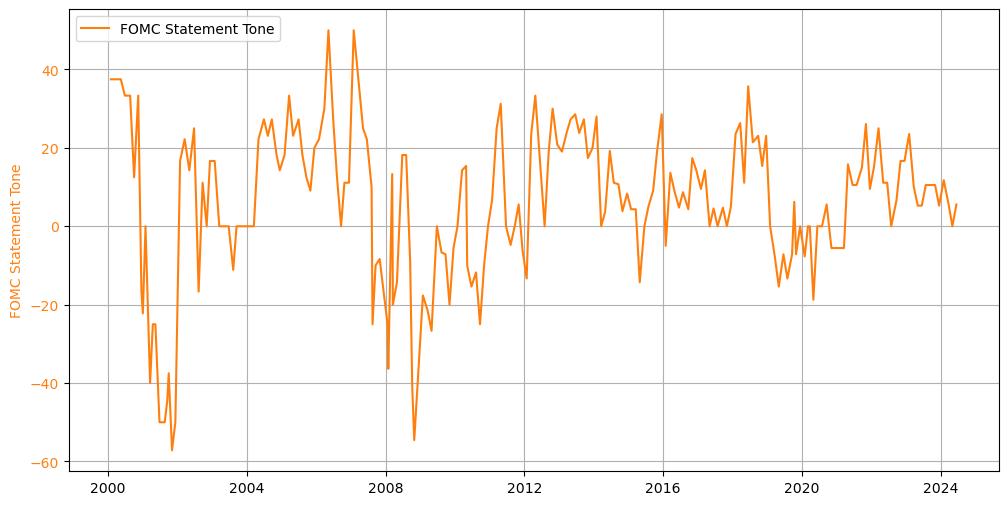

In [14]:
text_df['Date'] = pd.to_datetime(text_df['Date'])

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(text_df['Date'], text_df['index'], label='FOMC Statement Tone', color='tab:orange')
ax1.set_ylabel('FOMC Statement Tone', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

plt.grid(True)
ax1.legend(loc='upper left')
plt.show()

### Tone/index of FOMC statements with Fed Funds Effective Rate
 

**Fed Funds Effective Rate** (FFER) is the interest rate at which one depository institutions (such as banks and credit unions) lend reserve balances to other depository institutions overnight on an uncollateralized basis. This rate is determined by the market but is influenced by the Federal Reserve's open market operations. 

A **hawkish** tone in an FOMC statement normally indicates that the Committee is concerned about inflation and is more likely to increase interest rates. In this case, we think FOMC statement with **high index** typically leads to **expectations of higher FFER in the future**. 

A **dovish** tone in an FOMC statement normally indicates that the Committee is more focused on promoting economic growth and employment, often by lowering interest rates or keeping them low for an extended period. In this case, we think FOMC statement with **low index** typically leads to **expectations of lower FFER in the future**. 


In [15]:
# daily data of FFER from 2000-01 - 2024-07
dff = pd.read_csv("DFF.csv")
dff.head()

,DATE,DFF
0,2000-01-01,3.99
1,2000-01-02,3.99
2,2000-01-03,5.43
3,2000-01-04,5.38
4,2000-01-05,5.41


#### Plot of Tone of FOMC statements with Fed Funds Effective Rate

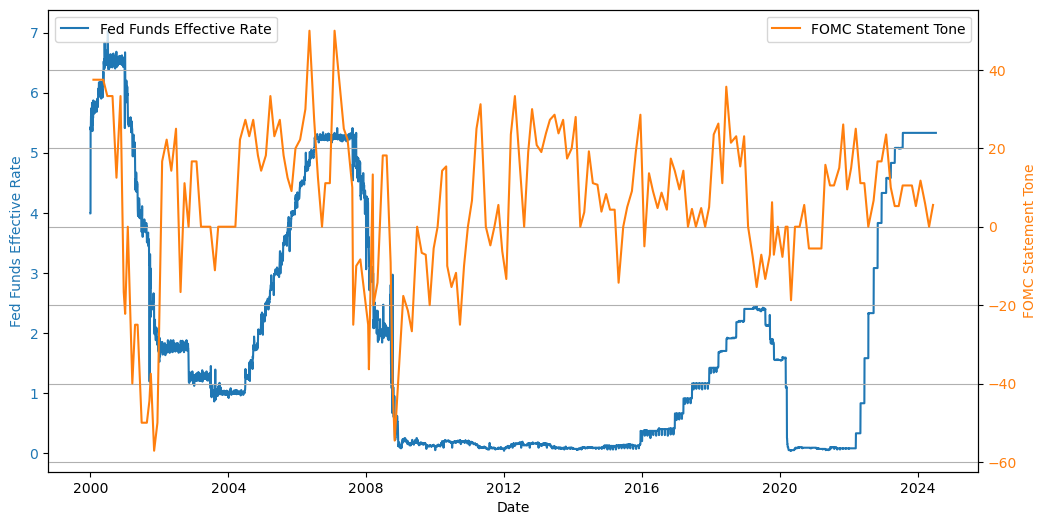

In [16]:
dff['DATE'] = pd.to_datetime(dff['DATE'])
text_df['Date'] = pd.to_datetime(text_df['Date'])

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(dff['DATE'], dff['DFF'], label='Fed Funds Effective Rate', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fed Funds Effective Rate', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(text_df['Date'], text_df['index'], label='FOMC Statement Tone', color='tab:orange')
ax2.set_ylabel('FOMC Statement Tone', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

#### Plot of Tone of FOMC statements with Fed Funds Effective Rate with same frenquence

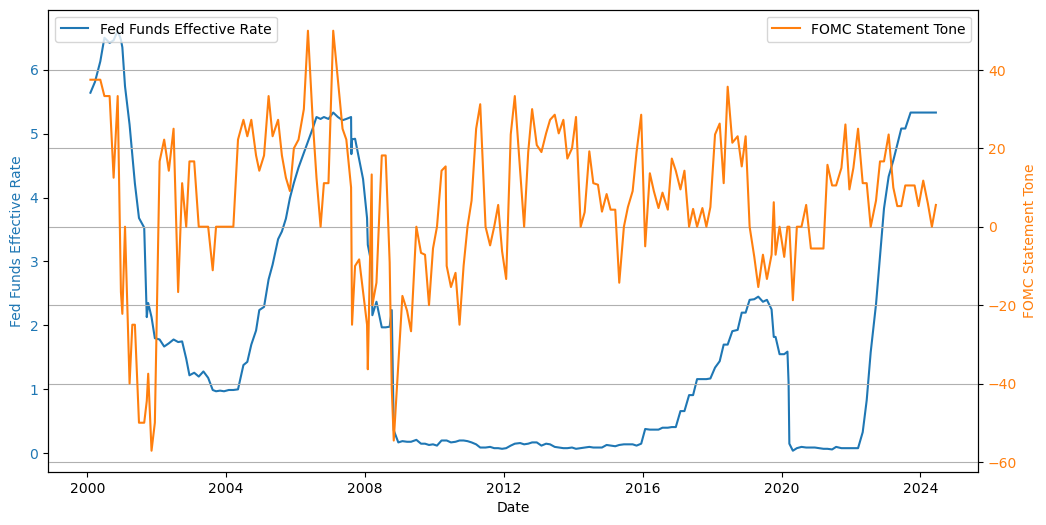

In [17]:
dff_filtered = dff[dff['DATE'].isin(text_df['Date'])]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(dff_filtered['DATE'], dff_filtered['DFF'], label='Fed Funds Effective Rate', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fed Funds Effective Rate', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(text_df['Date'], text_df['index'], label='FOMC Statement Tone', color='tab:orange')
ax2.set_ylabel('FOMC Statement Tone', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

There appears to be a correlation between the FFER and the FOMC Statement Tone. When the tone of the FOMC statements tends to be more hawkish (indicating an increase), the FFER tends to be high or increasing after some time. Conversely, when the tone tends to be more dovish (indicating a decrease), the FFER tends to be low or decreasing after a period.

The trends of the FOMC Statement Tone and the FFER curves are very similar. However, it seems that there is a time lag between them: FOMC Statement tone preceding changes in the FFER. Therefore, we aim to investigate the lagged relationship between the FOMC Statement Tone and the FFER.

### Correlation between Lagged FOMC Statement Tone and Fed Funds Effective Rate

In [18]:
merged_df = pd.merge(dff_filtered[['DATE', 'DFF']], text_df[['Date', 'index']], left_on='DATE', right_on='Date')

lag_correlation_df = pd.DataFrame(columns=['Lag', 'Correlation'])

# calculate the correlation from lag 0 to 40
for lag in range(41):
    
    merged_df[f'Index_lag_{lag}'] = merged_df['index'].shift(lag)

    correlation = merged_df['DFF'].corr(merged_df[f'Index_lag_{lag}'])

    lag_correlation_df = lag_correlation_df.append({'Lag': lag, 'Correlation': correlation}, ignore_index=True)

lag_correlation_df

,Lag,Correlation
0,0.0,0.081643
1,1.0,0.143485
2,2.0,0.204600
3,3.0,0.242089
4,4.0,0.270202
5,5.0,0.306591
6,6.0,0.330541
7,7.0,0.345957
8,8.0,0.367491
9,9.0,0.374580


In [19]:
lag_correlation_df['Correlation'].describe()

count    41.000000
mean      0.103405
std       0.213334
min      -0.204810
25%      -0.118721
50%       0.143485
75%       0.306591
max       0.379385
Name: Correlation, dtype: float64

#### Plot of Lagged 5 Tone of FOMC statements with Fed Funds Effective Rate

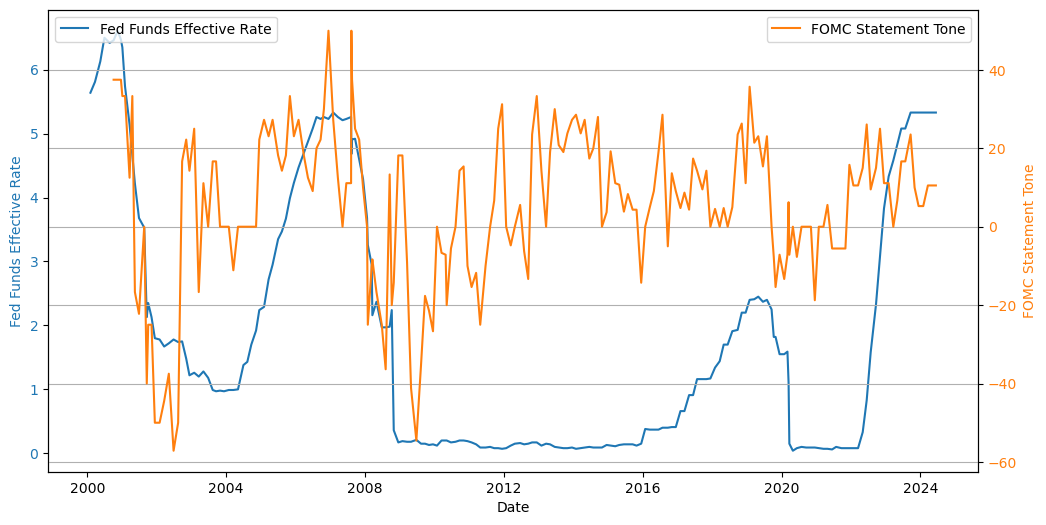

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_df['DATE'], merged_df['DFF'], label='Fed Funds Effective Rate', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fed Funds Effective Rate', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(merged_df['Date'], merged_df['Index_lag_5'], label='FOMC Statement Tone', color='tab:orange')
ax2.set_ylabel('FOMC Statement Tone', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

After lagging the FOMC Statement Tone by 5 periods, we found that the trend of the FFER curve closely aligns with the trend of the new FOMC Statement Tone curve, with minimal time lag. The correlation between these two variables is approximately 0.31. 

Typically, FOMC statements are released at intervals of 1 to 2 months. A lag of 5 periods corresponds to approximately six months, suggesting that the FFER adjusts in response to FOMC statements announced six months before. We consider this phenomenon to be reasonable as it's supported by our findings.

## Part 4: Empirical Analysis on FOMC Statement Tone Using Fama-Macbeth Method

### Step 1: Generate Monetary Policy Shock (FOMC Statement-based) 

We considered the tone of FOMC statements impacts market outcomes through two channels: predictable changes, which are indicated by past statements, and unpredictable changes, or shocks. According to economic theory, it is often the shock in monetary policy that significantly influence market outcomes.

To extract the unpredictable component, we estimate an **AR( 1 )** model from the FOMC statement tone data. The model is specified as follows:

$$
\text{Tone}_t = \alpha + \phi\ \text{Tone}_{t-1} + \epsilon_t \
$$

where:
- $\text{Tone}_t$ is the value of the FOMCE Statement Tone at time t
- $\alpha$ is constant
- $\phi$ is the parameter that determines the strength of the correlation between $\text{Tone}_t$ and $\text{Tone}_t-1$
- $\epsilon_t$ is the residual term at time t, called as **"monetary policy shock"**


In [21]:
text_df = text_df.sort_values(by='Date')

# AR(1)
model = AutoReg(text_df['index'], lags=1)
model_fitted = model.fit()

text_df['residuals'] = model_fitted.resid

text_df

,Date,Text,Words,Sentences,Filtered Sentences,Score,index,residuals
0,2000-02-02,The Federal Open Market Committee voted today ...,197,[the federal open market committee voted today...,[the federal open market committee voted today...,"[1, 1, 0, 1]",37.500000,NaN
1,2000-03-21,The Federal Open Market Committee voted today ...,203,[the federal open market committee voted today...,[the federal open market committee voted today...,"[1, 0, 1, 1]",37.500000,9.693542
2,2000-05-16,The Federal Open Market Committee voted today ...,196,[the federal open market committee voted today...,[the federal open market committee voted today...,"[1, 1, 0, 1]",37.500000,9.693542
3,2000-06-28,The Federal Open Market Committee at its meeti...,171,[the federal open market committee at its meet...,[the federal open market committee at its meet...,"[0, -1, 1, 1, 1]",33.333333,5.526875
4,2000-08-22,The Federal Open Market Committee at its meeti...,174,[the federal open market committee at its meet...,[the federal open market committee at its meet...,"[0, -1, 1, 1, 1]",33.333333,8.458080
...,...,...,...,...,...,...,...,...
203,2023-12-13,Recent indicators suggest that growth of econo...,371,[recent indicators suggest that growth of econ...,[recent indicators suggest that growth of econ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5.263158,-3.567608
204,2024-01-31,Recent indicators suggest that economic activi...,350,[recent indicators suggest that economic activ...,[recent indicators suggest that economic activ...,"[1, 0, 1, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0]",11.764706,6.636515
205,2024-03-20,Recent indicators suggest that economic activi...,344,[recent indicators suggest that economic activ...,[recent indicators suggest that economic activ...,"[1, -1, 1, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0]",5.882353,-3.819606
206,2024-05-01,Recent indicators suggest that economic activi...,422,[recent indicators suggest that economic activ...,[recent indicators suggest that economic activ...,"[1, -1, 1, 0, 0, 1, 0, 0, 0, -1, 0, -1, 0, 0, ...",0.000000,-5.563788


### Step 2: Time Sereis Regression

In our analysis, we downloaded value-weighted returns for 49 industry portfolios from the CRSP database. Following the Fama-MacBeth empirical test method, we first ran 49 time series regressions to calculate the coefficients of each industry portfolio's response to monetary policy shocks. Specifically, we want to know how each industry reacts to these shocks and to assess the significance of the beta coefficients. The regression model is specified as follows:
$$
\text{Return}_{i,t} = \alpha_i + \beta_i\ \text{Shock}_{t} + \epsilon_{i,t} \
$$

where:
- $\text{Return}_{i,t}$ is the daily return of industry i's portfolio at time t
- $\alpha_i$ is the constant for industry i's portfolio
- $\beta_i$ is the coefficient representing the response of industry i to the monetary policy shock
- $\text{Shock}_{t}$ is the monetary policy shock at time t
- $\epsilon_t$ is the residual  of industry i's portfolio at time t




In [22]:
industry_df = pd.read_csv('49_Industry_Portfolios_Daily1.CSV')

industry_df.dropna(inplace=True)  # drop NA values

industry_df.rename(columns={industry_df.columns[0]: 'Date'}, inplace=True)

industry_df['Date'] = pd.to_datetime(industry_df['Date'], format='%Y%m%d')

In [23]:
merged_df = pd.merge(text_df, industry_df, on='Date')
merged_df = merged_df.dropna()

In [24]:
industries = ['Agric', 'Food ', 'Soda ', 'Beer ', 'Smoke', 'Toys ', 'Fun  ', 'Books',
              'Hshld', 'Clths', 'Hlth ', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
              'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach ', 'ElcEq', 'Autos', 'Aero ',
              'Ships', 'Guns ', 'Gold ', 'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm',
              'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips', 'LabEq', 'Paper', 'Boxes',
              'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin  ',
              'Other']


results = []


for industry in industries:
    
    X = sm.add_constant(merged_df['residuals'])  # add constant
    y = merged_df[industry]
    
    model = sm.OLS(y, X).fit()
    
    coefficient = model.params['residuals']
    p_value = model.pvalues['residuals']
    
    results.append({
        'industry': industry.strip(),  
        'coefficient': coefficient,
        'p-value': p_value
    })


result_df = pd.DataFrame(results)

sorted_results_df = result_df.sort_values(by='p-value', ascending=True)

sorted_results_df

,industry,coefficient,p-value
12,Drugs,0.016670,0.005676
1,Food,0.013834,0.010506
37,LabEq,0.022050,0.018435
8,Hshld,0.011640,0.051342
3,Beer,0.010673,0.054870
31,Telcm,0.014654,0.060176
30,Util,0.012643,0.060672
41,Whlsl,0.012788,0.068932
28,Coal,-0.028830,0.070586
42,Rtail,0.014702,0.078165


According to the result above, there are three industries showing a sigificant **positive** response to monetary policy shocks at the 5% significance level: **Drugs, Food, and Laboratory Equipment.** The results aligns with oour expectation. The positive correlation/response suggests that during times of monetary shocks, people might still spend on essential goods(food industry) and medications (drugs industry). The reason of the positive response of laboratory equipment industry may be that it benefits from continued investment in healthcare and scientific research, which remain priorities despite higher borrowing costs.

### Step 3: Cross-Sectional Regression

Following the Fama-MacBeth empirical test method, we then conducted 200 cross-sectional regressions to calculate the monetary policy shocks risk premium at each time period. Specifically, we aimed to determine whether these industries exhibit a positive risk premium, and whether the risk premium is statistically significant. The model used for the regressions is as follows:
$$
\text{Return}_{i,T} = \alpha_T + \lambda_T\ \beta_i + \epsilon_{i,T} \
$$

where:
- $\text{Return}_{i,T}$ is the daily return of industry i's portfolio at time T
- $\alpha_T$ is the constant at time T
- $\beta_i$ is the coefficient representing the response of industry i to the monetary policy shock
- $\lambda_T$ is the risk premium associated with the monetary policy shock at time T
- $\epsilon_{i,T}$ is the residual of industry i's portfolio at time T




In [25]:
Month_industry_df = pd.read_csv('49_Industry_Portfolios1.CSV')

Month_industry_df.dropna(inplace=True)  # drop NA values

Month_industry_df.set_index(Month_industry_df.columns[0], inplace=True)
Month_industry_df.index.name = 'Date'
Month_industry_df = Month_industry_df.reset_index()

In [26]:
text_df['date'] = pd.to_datetime(text_df['Date'], format='%Y%m%d').dt.strftime('%Y-%m')
Month_industry_df['Date'] = pd.to_datetime(Month_industry_df['Date'].astype(str), format='%Y%m').dt.strftime('%Y-%m')

In [27]:
merged_month_df = pd.merge(text_df[['date']], Month_industry_df, left_on='date', right_on = 'Date',how='inner')

In [28]:
merged_month_df

,date,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,2000-02,2000-02,6.85,-7.16,-8.65,-11.65,-4.00,0.42,-3.32,-0.26,...,-12.78,-5.35,1.68,-4.16,-12.05,-11.30,-13.09,2.03,6.73,-1.40
1,2000-03,2000-03,4.35,10.37,-0.39,0.14,5.15,7.83,11.14,12.65,...,12.76,12.76,6.98,14.41,16.06,15.05,23.34,4.25,14.91,-2.01
2,2000-05,2000-05,-1.11,17.38,-7.24,11.89,19.52,1.13,1.35,-6.52,...,-2.39,-3.67,1.37,-3.13,-4.25,7.96,6.26,-2.42,-6.61,10.41
3,2000-06,2000-06,0.22,1.77,1.24,6.06,2.98,-1.69,-0.98,-0.22,...,-3.12,-1.86,-2.45,-1.96,-3.96,-9.89,-2.78,-1.44,14.48,3.02
4,2000-08,2000-08,-0.84,-2.98,-2.20,-10.94,19.12,1.98,5.67,2.33,...,1.61,-2.83,10.32,-5.29,-0.71,10.22,4.27,-0.06,18.60,13.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2023-02,2023-02,-3.37,-1.23,-2.67,0.21,-3.38,-3.79,-4.23,-4.63,...,-4.01,-0.35,-0.34,-5.53,-2.54,-2.71,-3.59,-2.28,-2.16,-2.38
197,2023-03,2023-03,-2.64,3.45,5.15,4.15,0.11,-1.23,3.04,-3.80,...,-0.81,-0.82,0.61,3.69,3.34,-11.37,-4.73,-8.18,-7.55,2.42
198,2023-05,2023-05,-10.94,-5.00,-3.82,-2.85,-8.73,-8.47,3.55,-0.64,...,-6.10,0.26,-1.27,2.08,-5.16,-3.98,-3.72,0.40,-3.64,-2.08
199,2023-06,2023-06,6.32,-0.74,1.37,2.79,7.77,10.73,9.38,6.03,...,7.86,11.63,11.60,7.94,5.76,7.06,3.75,9.49,5.90,6.73


In [29]:
industry_names = ['Agric', 'Food ', 'Soda ', 'Beer ', 'Smoke', 'Toys ', 'Fun  ', 'Books',
       'Hshld', 'Clths', 'Hlth ', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach ', 'ElcEq', 'Autos', 'Aero ',
       'Ships', 'Guns ', 'Gold ', 'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm',
       'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips', 'LabEq', 'Paper', 'Boxes',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin  ',
       'Other']

In [30]:
regression_results = []
industry_X_values = {}

for idx, row in result_df.iterrows():
    industry = row['industry']
    X_value = row['coefficient']
    industry_X_values[industry] = X_value

for idx, row in merged_month_df.iterrows():
    
    Y_values = [row[industry] for industry in industry_X_values.keys() if industry in merged_month_df.columns]
    
    X_values = [industry_X_values[industry] for industry in industry_X_values.keys() if industry in merged_month_df.columns]
    
    X = np.array(X_values)
    Y = np.array(Y_values)
    
    X = sm.add_constant(X)
    
    model = sm.OLS(Y, X).fit()

    if len(model.params) > 1:
        coef = model.params[1] 
    else:
        coef = None  
    
    regression_results.append([row['Date'], coef])

df = pd.DataFrame(regression_results, columns=['Date', 'Coefficient'])

In [31]:
df

,Date,Coefficient
0,2000-02,655.903861
1,2000-03,-231.365892
2,2000-05,-104.452643
3,2000-06,494.768033
4,2000-08,188.379704
...,...,...
196,2023-02,58.661559
197,2023-03,530.894816
198,2023-05,483.963394
199,2023-06,-329.696202


In [32]:
lambda_avg = df['Coefficient'].mean()
lambda_avg

26.408470754127272

The average $\lambda_T$ is approximately 26.41, indicating that for a one-unit increase in the exposure to monetary policy risk, assets are expected to yield an additional return of 26.41%. 

This is reasonable, since if a particular asset has a higher sensitivity or exposure to monetary policy changes, with the risk averse instinct, investors require compensation for bearing the added risk.

### Step 4: Statistical Testing on the Average Risk Premium

Following the Fama-MacBeth empirical test method, we constructed a **t-test** on the mean of risk premium $\lambda_T$. 

In [33]:
std_dev = df['Coefficient'].std()

# compute the t-statistic
sample_mean = lambda_avg
population_mean = 0
sample_size = len(df)
t_statistic = (sample_mean - population_mean) / (std_dev / np.sqrt(sample_size))

alpha_10 = 0.10
alpha_05 = 0.05
alpha_01 = 0.01

# critical t-values for two-tailed test
critical_t_10 = stats.t.ppf(1 - alpha_10/2, sample_size - 1)
critical_t_05 = stats.t.ppf(1 - alpha_05/2, sample_size - 1)
critical_t_01 = stats.t.ppf(1 - alpha_01/2, sample_size - 1)

significant_at_10 = np.abs(t_statistic) > critical_t_10
significant_at_05 = np.abs(t_statistic) > critical_t_05
significant_at_01 = np.abs(t_statistic) > critical_t_01

print(f"Standard Deviation of λ: {std_dev}")
print(f"t-statistic: {t_statistic}")
print(f"Significant at 10%: {significant_at_10}")
print(f"Significant at 5%: {significant_at_05}")
print(f"Significant at 1%: {significant_at_01}")

Standard Deviation of λ: 231.85318878253722
t-statistic: 1.614835203396903
Significant at 10%: False
Significant at 5%: False
Significant at 1%: False


The result does not support that the risk premium is different from zero at these levels of significance.

## Part 5: Future Works

While the results above do not indicate a nonzero risk premium associated with monetary policy shocks, we think that the impact of such shocks and their associated risk premiums do exist. Moving forward, there are several ways to further investigate whether the risk premium is greater than zero using the Fama-MacBeth method:

- **Use Stock Data instead of Portfolio Data:**
    - Directly employing individual stock data instead of industry portfolios may provide a risk premium. Industry portfolios aggregate individual stocks' diverse reactions to monetary policy shocks, thus stocks may potentially offsetting each other's effects within the portfolio. Using individual stock data offers higher granularity, allowing for a more precise assessment of how different stocks respond uniquely to monetary policy shocks.

- **Construct Monetary Policy Shocks Differently:**
    - The current approach apply AR(1) model for constructing monetary policy shocks. This method may not capture all relevant dynamics comprehensively. Exploring different method for constructing monetary policy shocks could provide additional insights.